In [1]:
import gensim
from gensim import corpora
from gensim import models
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import numpy as np
import random
from glob import glob
from string import punctuation

import random
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
from dateutil import parser
import numpy as np
from tqdm import tqdm

from nltk.tokenize import TreebankWordTokenizer

/Users/anne/Library/Python/3.8/lib/python/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [2]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /Users/anne/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
print(f"Your gensim version is {gensim.__version__}. This notebook assumes that you have version 4.0 or higher. If not, please upgrade.")
assert int(gensim.__version__[0])>=4

print(f"Your pyLDAvis version is {pyLDAvis.__version__}. This notebook assumes that you have version 3.0 or higher. If not, please upgrade.")
assert int(pyLDAvis.__version__[0])>=3

Your gensim version is 4.1.2. This notebook assumes that you have version 4.0 or higher. If not, please upgrade.
Your pyLDAvis version is 3.3.1. This notebook assumes that you have version 3.0 or higher. If not, please upgrade.


LDA is probabilistic method. As a consequence, you may find slight variations in results for different runs of the model. To make sure our findings are reproducable, we have to set a seed. In addition, we have to use `distributed=False` to get reproducable findings. 

In [9]:
random.seed(2022)
np.random.seed(2022)

# Working with textual data

### 0. Get the data.

- Download  `articles.tar.gz` or `articles.zip` from Canvas (under `Modules -- Materials LDA notebook`). Please note that this is not the full dataset, but random sample of the data described [here](https://dx.doi.org/10.7910/DVN/ULHLCB).


<div class="alert-danger">
<p>Alternatively, you can also download <code>articles.tar.gz</code> from
<a href="https://dx.doi.org/10.7910/DVN/ULHLCB">https://dx.doi.org/10.7910/DVN/ULHLCB</a> to get <strong>all</strong> the data. Please note that this is a very large dataset, and for practice purposes, you do not need everything. </p>
</div>



- Unpack it. On Linux and MacOS, you can do this with `tar -xzf mydata.tar.gz` on the command line. On Windows, you may need an additional tool such as `7zip` for that (note that technically speaking, there is a `tar` archive within a `gz` archive, so unpacking may take *two* steps depending on your tool).


### 1. Inspect the structure of the dataset.
What information do the following elements give you?

- folder (directory) names
- folder structure/hierarchy
- file names
- file contents

### 2. Discuss strategies for working with this dataset!

- Which questions could you answer?
- How could you deal with it, given the size and the structure?

### 3. Read some (or all?) data

Here is some example code that you can modify. you could, for instance, do the following to read a *part* of your dataset.

In [10]:
## load data
PATH = "articles" #unzip or untar the folder with articles, and place them in the current working directory. 

In [11]:
RANDOM_N = 2000

## Helper function to read in the data. 
# Don't panic if you do not understand each line of code; try to follow along--but we do not expect you to write such helper functions yourself from scratch

def read_data(listofoutlets, RANDOM_N, PATH = PATH):
    date = []
    title = []
    outlets = []
    texts = []
    for outlet in listofoutlets:
        
        for file in random.choices(glob(f'{PATH}/*/{outlet}/*'), k=RANDOM_N):
            date.append(file.split('--')[-2])
            title.append(file.split('--')[-1])
            with open(file) as f:
                texts.append(f.read())
                outlets.append(outlet)
    return date, title, texts, outlets

dates, title, texts, outlets = read_data(['Infowars'], RANDOM_N)

In [12]:
len(texts)

2000

In [13]:
texts[0][:500]

'No society should function with this level of inequality (with the possible exception of one of those prison planets in a Star Wars movie). Sixty-three percent of Americans cant afford a $500 emergency. Yet Amazon head Jeff Bezos is now worth a record $141 billion. He could literally end world hunger for multiple years and still have more money left over than he could ever spend on himself.\n\nWorldwide, one in 10 people only make $2 a day. Do you know how long it would take one of those people to'

In [15]:
texts_clean = [text.lower() for text in texts]
texts_clean=[" ".join(text.split()) for text in texts_clean]  #remove dubble spaces
texts_clean = ["".join([l for l in text if l not in punctuation]) for text in texts_clean] #remove punctuaction
texts_clean[0][:500]

'former white house aide rob porter who recently resigned amidst controversy regarding alleged spousal abuse played a key role in the suppression of information to president trump namely articles published by infowars while delving into the ongoing firestorm surrounding porter radio host rush limbaugh recalled that the departed white house secretary had worked closely under chief of staff john kelly in enacting new policies designed to restrict which news stories and media reports were passed on '

## manually removing stopwords

In [16]:
mystopwords = set(stopwords.words('english')) # use default NLTK stopword list; alternatively:
# mystopwords = set(open('mystopwordfile.txt').readlines())  #read stopword list from a textfile with one stopword per line

texts_clean = [" ".join(word for word in text.split() if word not in mystopwords) for text in texts_clean]
texts_clean[0][:500]

'former white house aide rob porter recently resigned amidst controversy regarding alleged spousal abuse played key role suppression information president trump namely articles published infowars delving ongoing firestorm surrounding porter radio host rush limbaugh recalled departed white house secretary worked closely chief staff john kelly enacting new policies designed restrict news stories media reports passed president hes credited working chief staff control flow information president limba'

## Tokenize texts

In [17]:
tokenized_texts_clean = [TreebankWordTokenizer().tokenize(text) for text in texts_clean ] # tokenize texts; convert all strings to a list of tokens
tokenized_texts_clean[0][:500]

['former',
 'white',
 'house',
 'aide',
 'rob',
 'porter',
 'recently',
 'resigned',
 'amidst',
 'controversy',
 'regarding',
 'alleged',
 'spousal',
 'abuse',
 'played',
 'key',
 'role',
 'suppression',
 'information',
 'president',
 'trump',
 'namely',
 'articles',
 'published',
 'infowars',
 'delving',
 'ongoing',
 'firestorm',
 'surrounding',
 'porter',
 'radio',
 'host',
 'rush',
 'limbaugh',
 'recalled',
 'departed',
 'white',
 'house',
 'secretary',
 'worked',
 'closely',
 'chief',
 'staff',
 'john',
 'kelly',
 'enacting',
 'new',
 'policies',
 'designed',
 'restrict',
 'news',
 'stories',
 'media',
 'reports',
 'passed',
 'president',
 'hes',
 'credited',
 'working',
 'chief',
 'staff',
 'control',
 'flow',
 'information',
 'president',
 'limbaugh',
 'said',
 'means',
 'trump',
 'gets',
 'less',
 'breitbart',
 'less',
 'infowars',
 'politico',
 'mainstream',
 'news',
 'used',
 'according',
 'weve',
 'told',
 'oval',
 'office',
 'door',
 'open',
 'could',
 'walk',
 'anything',
 

## prepare the corpus for topic modelling

In [18]:
raw_m1 = tokenized_texts_clean
id2word_m1 = corpora.Dictionary(raw_m1)   # assign a token_id to each word
ldacorpus_m1 = [id2word_m1.doc2bow(text) for text in raw_m1] 

lda_m1 = models.LdaModel(ldacorpus_m1, id2word=id2word_m1, num_topics=10)
lda_m1.print_topics()

[(0,
  '0.012*"trump" + 0.007*"said" + 0.007*"people" + 0.006*"president" + 0.004*"cnn" + 0.004*"news" + 0.003*"us" + 0.003*"one" + 0.003*"donald" + 0.003*"media"'),
 (1,
  '0.007*"trump" + 0.005*"said" + 0.004*"president" + 0.004*"would" + 0.004*"also" + 0.004*"one" + 0.004*"news" + 0.004*"new" + 0.003*"paul" + 0.003*"people"'),
 (2,
  '0.012*"trump" + 0.006*"president" + 0.006*"said" + 0.005*"people" + 0.004*"state" + 0.004*"would" + 0.003*"one" + 0.003*"democrats" + 0.003*"us" + 0.003*"even"'),
 (3,
  '0.011*"trump" + 0.008*"said" + 0.006*"president" + 0.004*"people" + 0.004*"us" + 0.004*"would" + 0.003*"one" + 0.003*"cnn" + 0.003*"fbi" + 0.003*"new"'),
 (4,
  '0.008*"said" + 0.007*"trump" + 0.005*"people" + 0.005*"also" + 0.004*"us" + 0.004*"fbi" + 0.004*"one" + 0.004*"would" + 0.004*"president" + 0.003*"media"'),
 (5,
  '0.010*"trump" + 0.009*"said" + 0.008*"president" + 0.004*"also" + 0.004*"people" + 0.004*"white" + 0.003*"house" + 0.003*"trumps" + 0.003*"one" + 0.003*"according

### Use TFidF instead of word counts

In [19]:
ldacorpus_m2 = ldacorpus_m1 # reuse corpus from Model 1 
id2word_m2 = id2word_m1 # and thus, also use id2word-mapping

tfidfcorpus_m2 = models.TfidfModel(ldacorpus_m2)

lda_m2 = models.ldamodel.LdaModel(corpus=tfidfcorpus_m2[ldacorpus_m2],id2word=id2word_m2,num_topics=10)
lda_m2.print_topics(num_words=5)

[(0,
  '0.001*"trump" + 0.001*"infowars" + 0.001*"president" + 0.001*"campaign" + 0.001*"media"'),
 (1,
  '0.001*"trump" + 0.001*"children" + 0.001*"said" + 0.001*"media" + 0.001*"new"'),
 (2,
  '0.001*"trump" + 0.001*"democrats" + 0.001*"said" + 0.001*"democratic" + 0.001*"people"'),
 (3,
  '0.001*"trump" + 0.001*"jones" + 0.001*"alex" + 0.001*"border" + 0.001*"said"'),
 (4,
  '0.001*"trump" + 0.001*"percent" + 0.001*"democrats" + 0.001*"president" + 0.001*"people"'),
 (5,
  '0.001*"trump" + 0.001*"president" + 0.001*"cnn" + 0.001*"said" + 0.001*"police"'),
 (6,
  '0.001*"trump" + 0.001*"school" + 0.001*"president" + 0.001*"white" + 0.001*"said"'),
 (7,
  '0.001*"trump" + 0.001*"president" + 0.001*"said" + 0.001*"fbi" + 0.001*"democrats"'),
 (8,
  '0.001*"trump" + 0.001*"president" + 0.001*"jones" + 0.001*"would" + 0.001*"students"'),
 (9,
  '0.001*"trump" + 0.001*"said" + 0.001*"president" + 0.001*"news" + 0.001*"cnn"')]

### Using N-grams as features

In [20]:
documents_bigrams = [["_".join(tup) for tup in nltk.ngrams(text.split(),2)] for text in texts_clean] # creates bigrams
documents_bigrams[0][:500] # inspect the results...

['former_white',
 'white_house',
 'house_aide',
 'aide_rob',
 'rob_porter',
 'porter_recently',
 'recently_resigned',
 'resigned_amidst',
 'amidst_controversy',
 'controversy_regarding',
 'regarding_alleged',
 'alleged_spousal',
 'spousal_abuse',
 'abuse_played',
 'played_key',
 'key_role',
 'role_suppression',
 'suppression_information',
 'information_president',
 'president_trump',
 'trump_namely',
 'namely_articles',
 'articles_published',
 'published_infowars',
 'infowars_delving',
 'delving_ongoing',
 'ongoing_firestorm',
 'firestorm_surrounding',
 'surrounding_porter',
 'porter_radio',
 'radio_host',
 'host_rush',
 'rush_limbaugh',
 'limbaugh_recalled',
 'recalled_departed',
 'departed_white',
 'white_house',
 'house_secretary',
 'secretary_worked',
 'worked_closely',
 'closely_chief',
 'chief_staff',
 'staff_john',
 'john_kelly',
 'kelly_enacting',
 'enacting_new',
 'new_policies',
 'policies_designed',
 'designed_restrict',
 'restrict_news',
 'news_stories',
 'stories_media',
 

In [21]:
# maybe we want both unigrams and bigrams in the feature set?
documents_uniandbigrams = []
for a,b in zip([text.split() for text in texts_clean],documents_bigrams):
    documents_uniandbigrams.append(a + b)

#and let's inspect the outcomes again.
documents_uniandbigrams[0]

len(documents_uniandbigrams[0]),len(documents_bigrams[0]),len(texts_clean[0].split())

(807, 403, 404)

In [22]:
id2word_m3 = corpora.Dictionary(documents_uniandbigrams)
id2word_m3.filter_extremes(no_below=5, no_above=0.5)

ldacorpus_m3 = [id2word_m3.doc2bow(text) for text in documents_uniandbigrams]
tfidfcorpus_m3 = models.TfidfModel(ldacorpus_m3)

lda_m3 = models.ldamodel.LdaModel(corpus=tfidfcorpus_m3[ldacorpus_m3],id2word=id2word_m3,num_topics=10)
lda_m3.print_topics(num_words=5)

[(0,
  '0.001*"trump" + 0.001*"people" + 0.001*"said" + 0.001*"state" + 0.001*"border"'),
 (1,
  '0.001*"trump" + 0.001*"people" + 0.001*"white" + 0.001*"gun" + 0.001*"infowars"'),
 (2,
  '0.001*"trump" + 0.001*"jones" + 0.001*"president" + 0.001*"border" + 0.001*"alex"'),
 (3,
  '0.001*"trump" + 0.001*"media" + 0.001*"kavanaugh" + 0.001*"infowars" + 0.001*"president"'),
 (4,
  '0.001*"trump" + 0.001*"kavanaugh" + 0.001*"said" + 0.001*"president" + 0.001*"white"'),
 (5,
  '0.001*"infowars" + 0.001*"trump" + 0.001*"media" + 0.001*"fbi" + 0.001*"said"'),
 (6,
  '0.001*"trump" + 0.001*"president" + 0.001*"border" + 0.001*"said" + 0.001*"us"'),
 (7,
  '0.002*"trump" + 0.001*"president" + 0.001*"jones" + 0.001*"police" + 0.001*"new"'),
 (8,
  '0.001*"trump" + 0.001*"president" + 0.001*"cnn" + 0.001*"said" + 0.001*"fbi"'),
 (9,
  '0.001*"trump" + 0.001*"said" + 0.001*"fbi" + 0.001*"infowars" + 0.001*"also"')]

# 2. Model evaluation

In [24]:
# NB: CoherenceModel is only available in newer versions of gensim.
# if it's not available, consider upgrading with `pip3 install gensim -upgrade`

#The smallest number/ 'lowest point' indicates the best coherence 

cm1 = models.CoherenceModel(model=lda_m1, corpus=ldacorpus_m1 , dictionary=id2word_m1, coherence='u_mass')  
ch1 = cm1.get_coherence()
cm2 = models.CoherenceModel(model=lda_m2, corpus=ldacorpus_m2, dictionary= id2word_m2, coherence='u_mass')  
ch2 = cm2.get_coherence()
#cm3 = models.CoherenceModel(model=lda_m3, corpus=ldacorpus_m3, coherence='u_mass')
cm3 = models.CoherenceModel(model=lda_m3, corpus=tfidfcorpus_m3[ldacorpus_m3], dictionary= id2word_m3, coherence='u_mass')
ch3 = cm3.get_coherence()

print(f"Coherence of naive model = {ch1}\nCoherence of tfidf model = {ch2}\nCoherence of bigram and unigram model = {ch3}")

Coherence of naive model = -1.4140621244534848
Coherence of tfidf model = -2.3749453688666606
Coherence of bigram and unigram model = -2.0647806219814653


In [25]:
lda_m2_bad = models.LdaModel(tfidfcorpus_m2[ldacorpus_m2],id2word=id2word_m2, num_topics=10,iterations=1)
print(models.CoherenceModel(model=lda_m2_bad, corpus=tfidfcorpus_m2[ldacorpus_m2], coherence='u_mass').get_coherence())

#lda_m2_good = models.LdaModel(tfidfcorpus_m4[ldacorpus_m4], id2word=id2word_m4, num_topics=10,iterations=50, passes=5)
#print(models.CoherenceModel(model=lda_m4_good, corpus=tfidfcorpus_m4[ldacorpus_m4], coherence='u_mass').get_coherence())

-1.7832451018820492


In [26]:
lda_m2_good = models.LdaModel(tfidfcorpus_m2[ldacorpus_m2],id2word=id2word_m2, num_topics=10,iterations=50, passes=5)
print(models.CoherenceModel(model=lda_m2_good, corpus=tfidfcorpus_m2[ldacorpus_m2], coherence='u_mass').get_coherence())

-5.134221333923149


In [27]:
lda_m2_good.top_topics(tfidfcorpus_m2[ldacorpus_m2])

[([(0.0016557233, 'trump'),
   (0.0012779862, 'news'),
   (0.0012422762, 'said'),
   (0.0011585992, 'one'),
   (0.0011175253, 'fbi'),
   (0.0010777843, 'people'),
   (0.0010737053, 'president'),
   (0.0010696563, 'would'),
   (0.0009782744, 'us'),
   (0.0009099573, 'media'),
   (0.0009099417, 'kavanaugh'),
   (0.0009009329, 'democrats'),
   (0.0008998004, 'get'),
   (0.0008968189, 'know'),
   (0.0008861831, 'go'),
   (0.0008832621, 'going'),
   (0.00087184337, 'times'),
   (0.0008709521, 'time'),
   (0.00086184905, 'investigation'),
   (0.0008590011, 'new')],
  -1.4736724066190086),
 ([(0.0014818477, 'kavanaugh'),
   (0.0013616411, 'trump'),
   (0.0011583301, 'fbi'),
   (0.0010352664, 'jones'),
   (0.0010220333, 'police'),
   (0.000997585, 'infowars'),
   (0.000965452, 'school'),
   (0.0009511288, 'president'),
   (0.0009162395, 'alex'),
   (0.00091526634, 'senator'),
   (0.0009088744, 'said'),
   (0.00087584526, 'people'),
   (0.00087128446, 'white'),
   (0.00086939853, 'man'),
   (0.

## Visualize

In [28]:
vis_data = gensimvis.prepare(lda_m2,ldacorpus_m2,id2word_m2)
pyLDAvis.display(vis_data)

## plot over time

In [22]:
## convert back to df

/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
all_topics = lda_m2.get_document_topics(ldacorpus_m2, minimum_probability=0.0)
all_topics_csr = gensim.matutils.corpus2csc(all_topics)
all_topics_numpy = all_topics_csr.T.toarray()
all_topics_df = pd.DataFrame(all_topics_numpy)
all_topics_df.head()

,0,1,2,3,4,5,6,7,8,9
0,0.033665,0.345777,0.000255,0.240517,0.000255,0.000255,0.000255,0.301311,0.077453,0.000255
1,0.000613,0.000613,0.000613,0.000613,0.000613,0.000613,0.088463,0.906631,0.000613,0.000613
2,0.000755,0.000755,0.000755,0.942996,0.000755,0.000755,0.000755,0.050964,0.000755,0.000755
3,0.000854,0.000854,0.535159,0.000854,0.381117,0.000854,0.000854,0.061629,0.016970,0.000854
4,0.000326,0.000326,0.000326,0.000326,0.000326,0.054713,0.000326,0.942682,0.000326,0.000326


In [30]:
all_topics_df.rename(columns= { 0 : "topic_0", 1 : "topic_1", 2 : "topic_2", 3 : "topic_3",
4 : "topic_4", 5 : "topic_5", 6 : "topic_6", 7 : "topic_7", 8 : "topic_8", 9 : "topic_9" },inplace=True)
all_topics_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.033665,0.345777,0.000255,0.240517,0.000255,0.000255,0.000255,0.301311,0.077453,0.000255
1,0.000613,0.000613,0.000613,0.000613,0.000613,0.000613,0.088463,0.906631,0.000613,0.000613
2,0.000755,0.000755,0.000755,0.942996,0.000755,0.000755,0.000755,0.050964,0.000755,0.000755
3,0.000854,0.000854,0.535159,0.000854,0.381117,0.000854,0.000854,0.061629,0.016970,0.000854
4,0.000326,0.000326,0.000326,0.000326,0.000326,0.054713,0.000326,0.942682,0.000326,0.000326


In [31]:
### create a df with the dates and orginal texts

meta = pd.DataFrame(zip(dates, texts))
meta.rename(columns = {0: "date", 1 : "texts"}, inplace=True)

meta.head()

,date,texts
0,2018-02-09,"Former White House aide Rob Porter, who recent..."
1,2018-07-23,Sen. Rand Paul stated Monday that he intends t...
2,2018-02-05,California Rep. Adam Schiff suggested that an ...
3,2018-10-22,With midterm elections right around the corner...
4,2018-10-19,Self-proclaimed future House Speaker Nancy Pel...


In [32]:
### merge with the topic scores per document

final = pd.concat([meta, all_topics_df], axis=1)
final['id'] = final.index
final.head(3)

,date,texts,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,id
0,2018-02-09,"Former White House aide Rob Porter, who recent...",0.033665,0.345777,0.000255,0.240517,0.000255,0.000255,0.000255,0.301311,0.077453,0.000255,0
1,2018-07-23,Sen. Rand Paul stated Monday that he intends t...,0.000613,0.000613,0.000613,0.000613,0.000613,0.000613,0.088463,0.906631,0.000613,0.000613,1
2,2018-02-05,California Rep. Adam Schiff suggested that an ...,0.000755,0.000755,0.000755,0.942996,0.000755,0.000755,0.000755,0.050964,0.000755,0.000755,2


In [33]:
### reshape to long format

long = pd.melt(final, id_vars=['id', 'date', 'texts'], value_vars=[f"topic_{i}" for i in range(0,10)])
long.rename(columns={"variable" : "topic_nr", "value" : "topic_score"}, inplace=True)
long.head(3)

,id,date,texts,topic_nr,topic_score
0,0,2018-02-09,"Former White House aide Rob Porter, who recent...",topic_0,0.033665
1,1,2018-07-23,Sen. Rand Paul stated Monday that he intends t...,topic_0,0.000613
2,2,2018-02-05,California Rep. Adam Schiff suggested that an ...,topic_0,0.000755


In [34]:
# get data in right shape for plotting
import seaborn as sns

long['date'] = long['date'].map(pd.to_datetime)
#plotdf = long.groupby(['topic_nr',pd.Grouper(key='date', freq='M')]).sum().reset_index() 
#plotdf = long.groupby(['topic_nr',pd.Grouper(key='date', freq='M')]).mean().reset_index() #you may also opt for 'mean'

long['month'] = pd.DatetimeIndex(long['date']).month

<AxesSubplot:xlabel='month', ylabel='topic_score'>

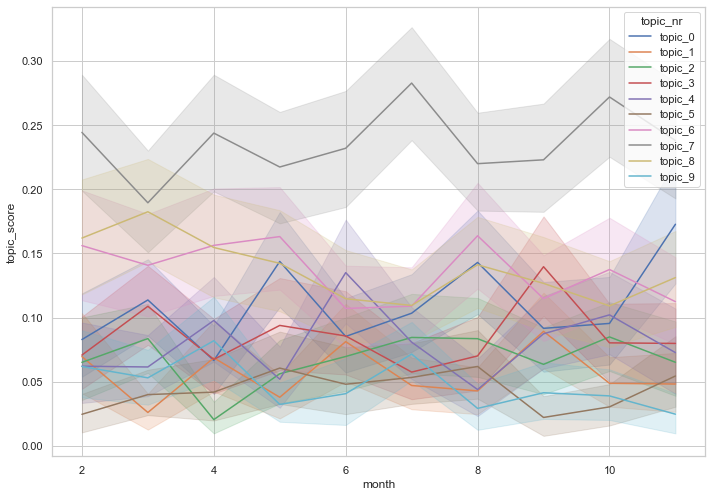

In [35]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("whitegrid")

sns.lineplot(x="month", y="topic_score", hue="topic_nr", data=long)